# EPFL Machine Learning, Project 1, CERN Dataset

In [66]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from proj1_helpers import load_csv_data
from cross_validation import cross_validation

In [67]:
train_set = load_csv_data('../train.csv')

In [68]:
y_train, X_train, ids, columns = train_set

print("X_train shape: {}".format(X_train.shape))
print("\ny_train shape: {}".format(y_train.shape))
print("\nColumn names: {}".format(columns))
print("\nColumn shape: {}".format(columns.shape))

n_features = len(columns)

X_train shape: (250000, 30)

y_train shape: (250000,)

Column names: ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt']

Column shape: (30,)


## Feature Engineering

Showing the features in histograms.

First of all, let's find how many meaningless value that each feature has.

In [69]:
print("Signal: {}".format(np.sum(y_train > 0)))
print("Background: {}".format(np.sum(y_train == 0)))

Signal: 85667
Background: 164333


In [70]:
for i in range(n_features):
    print("{} - {}: {}".format(i, columns[i], len(np.array([x for x in X_train[:,i] if x == -999]))))

0 - DER_mass_MMC: 38114
1 - DER_mass_transverse_met_lep: 0
2 - DER_mass_vis: 0
3 - DER_pt_h: 0
4 - DER_deltaeta_jet_jet: 177457
5 - DER_mass_jet_jet: 177457
6 - DER_prodeta_jet_jet: 177457
7 - DER_deltar_tau_lep: 0
8 - DER_pt_tot: 0
9 - DER_sum_pt: 0
10 - DER_pt_ratio_lep_tau: 0
11 - DER_met_phi_centrality: 0
12 - DER_lep_eta_centrality: 177457
13 - PRI_tau_pt: 0
14 - PRI_tau_eta: 0
15 - PRI_tau_phi: 0
16 - PRI_lep_pt: 0
17 - PRI_lep_eta: 0
18 - PRI_lep_phi: 0
19 - PRI_met: 0
20 - PRI_met_phi: 0
21 - PRI_met_sumet: 0
22 - PRI_jet_num: 0
23 - PRI_jet_leading_pt: 99913
24 - PRI_jet_leading_eta: 99913
25 - PRI_jet_leading_phi: 99913
26 - PRI_jet_subleading_pt: 177457
27 - PRI_jet_subleading_eta: 177457
28 - PRI_jet_subleading_phi: 177457
29 - PRI_jet_all_pt: 0


We are checking if the features that have same number of meaningless values have them in the same element in the dataset

In [71]:
print("For 177457\n")
print("DER_deltaeta_jet_jet = DER_mass_jet_jet: {}".format(
    np.array_equal(np.where(X_train[:,4] == -999)[0], np.where(X_train[:,5] == -999)[0])))
print("DER_deltaeta_jet_jet = DER_prodeta_jet_jet: {}".format(
    np.array_equal(np.where(X_train[:,4] == -999)[0], np.where(X_train[:,6] == -999)[0])))
print("DER_deltaeta_jet_jet = DER_lep_eta_centrality: {}".format(
    np.array_equal(np.where(X_train[:,4] == -999)[0], np.where(X_train[:,12] == -999)[0])))
print("DER_deltaeta_jet_jet = PRI_jet_subleading_pt: {}".format(
    np.array_equal(np.where(X_train[:,4] == -999)[0], np.where(X_train[:,26] == -999)[0])))
print("DER_deltaeta_jet_jet = PRI_jet_subleading_eta: {}".format(
    np.array_equal(np.where(X_train[:,4] == -999)[0], np.where(X_train[:,27] == -999)[0])))
print("DER_deltaeta_jet_jet = PRI_jet_subleading_phi: {}".format(
    np.array_equal(np.where(X_train[:,4] == -999)[0], np.where(X_train[:,28] == -999)[0])))
print("\nFor 99913\n")
print("PRI_jet_leading_pt = PRI_jet_leading_eta: {}".format(
    np.array_equal(np.where(X_train[:,23] == -999)[0], np.where(X_train[:,24] == -999)[0])))
print("PRI_jet_leading_pt = PRI_jet_leading_phi: {}".format(
    np.array_equal(np.where(X_train[:,23] == -999)[0], np.where(X_train[:,25] == -999)[0])))

For 177457

DER_deltaeta_jet_jet = DER_mass_jet_jet: True
DER_deltaeta_jet_jet = DER_prodeta_jet_jet: True
DER_deltaeta_jet_jet = DER_lep_eta_centrality: True
DER_deltaeta_jet_jet = PRI_jet_subleading_pt: True
DER_deltaeta_jet_jet = PRI_jet_subleading_eta: True
DER_deltaeta_jet_jet = PRI_jet_subleading_phi: True

For 99913

PRI_jet_leading_pt = PRI_jet_leading_eta: True
PRI_jet_leading_pt = PRI_jet_leading_phi: True


Let's examine the histograms of features without considering the meaningless values.

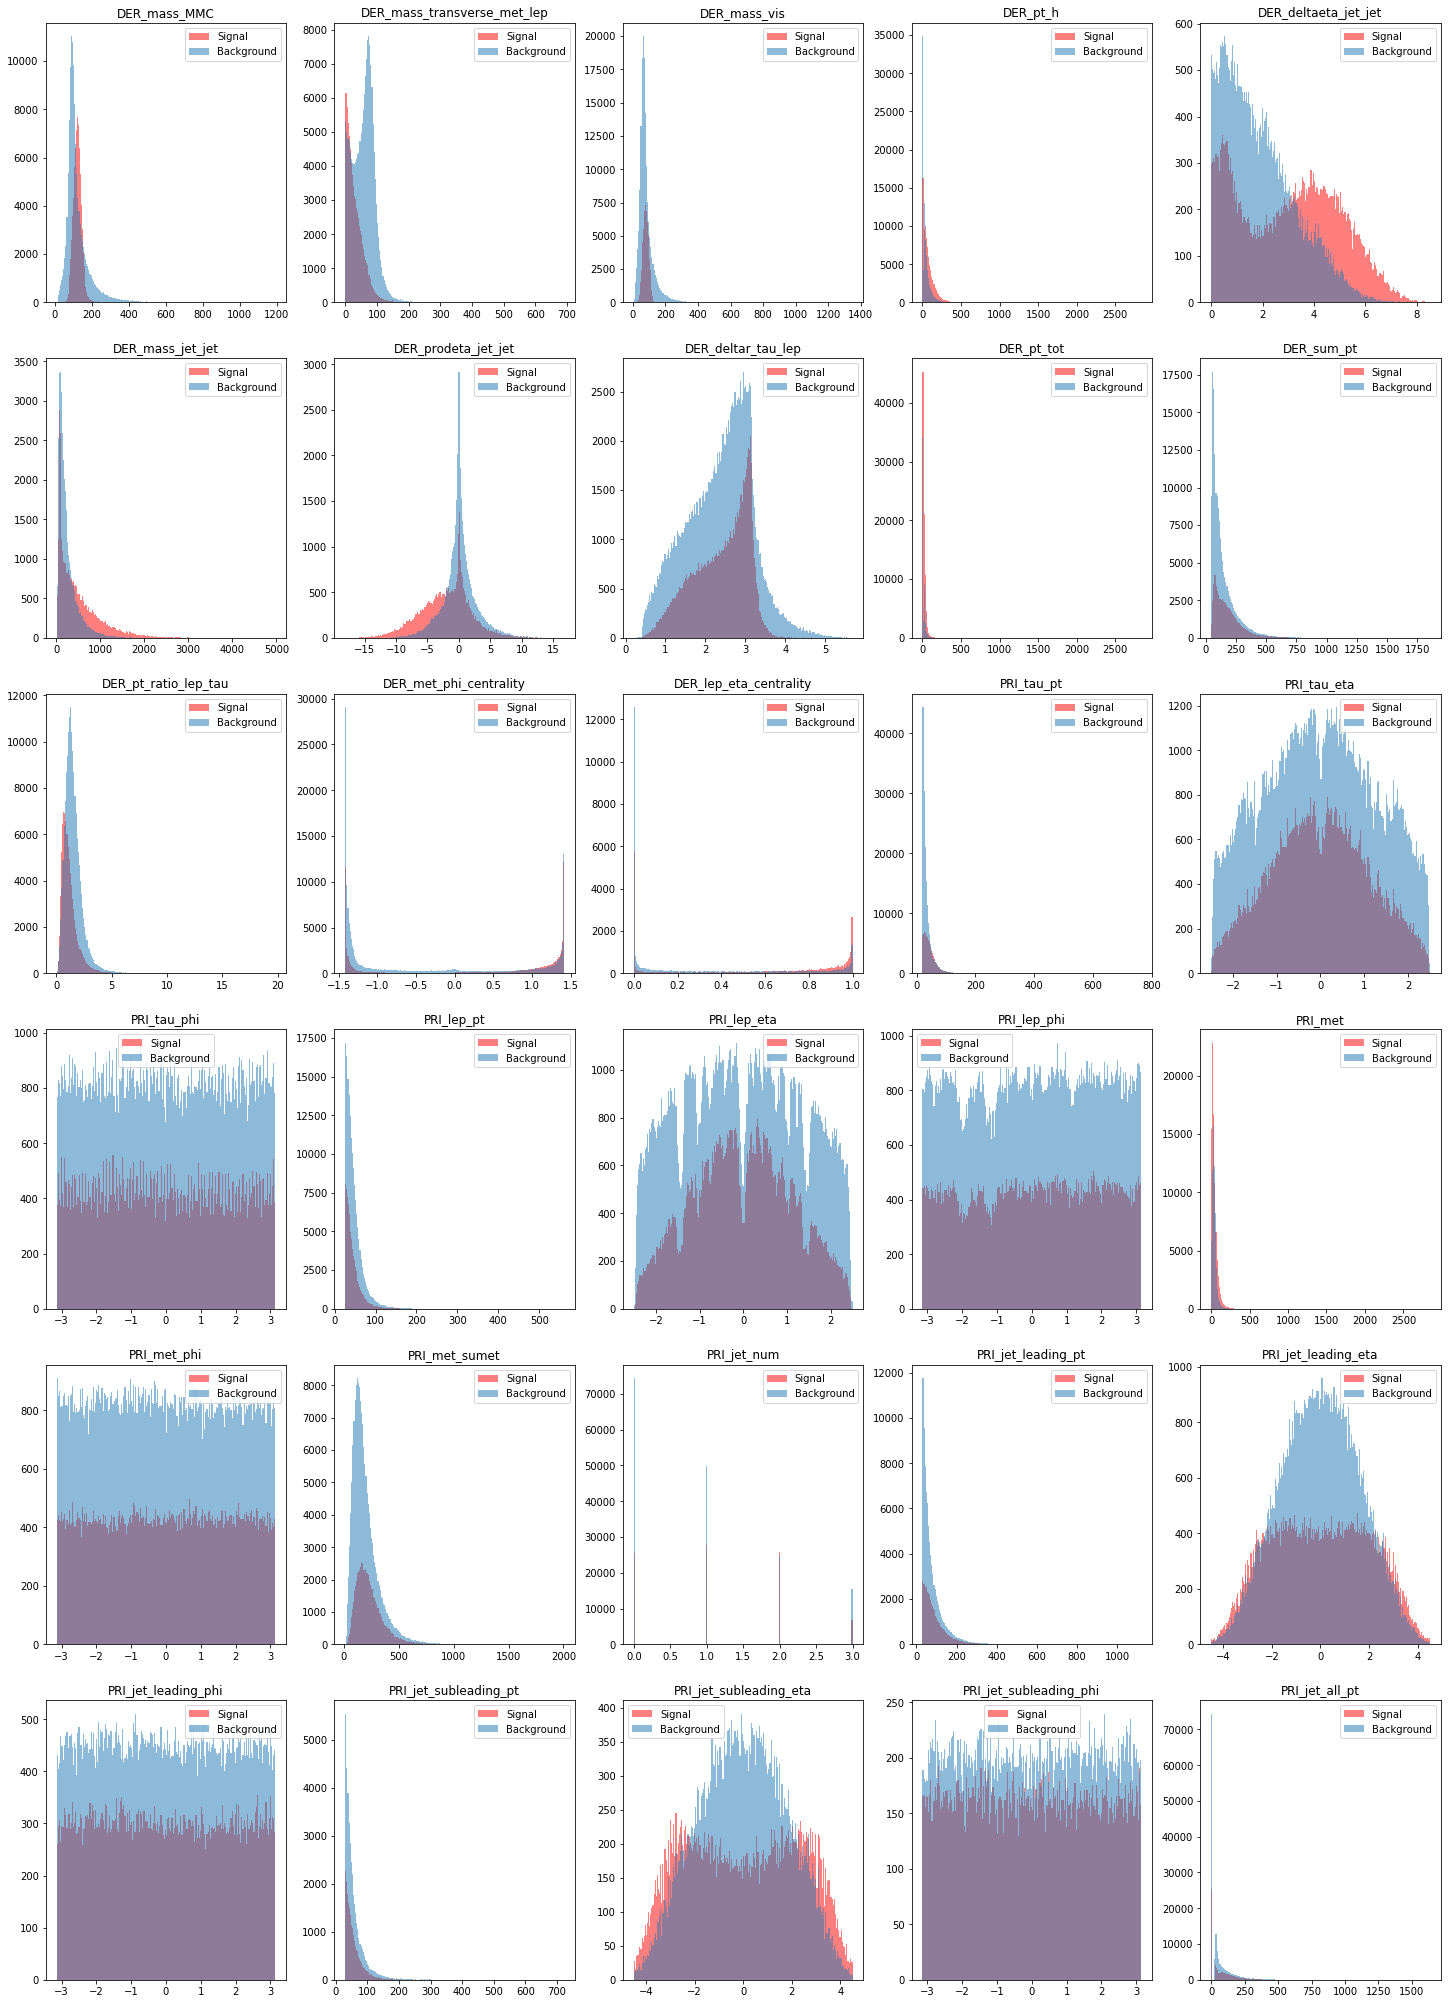

In [72]:
fig, axs = plt.subplots(6, 5, figsize=(25,36))
counter = 0
# We can set the number of bins with the `bins` kwarg
for i in range(6):
    for j in range(5):
        axs[i,j].hist(np.array([x for j,x in enumerate(X_train[:,counter]) if (x != -999 and y_train[j] == 1)]), 
                      bins=200, alpha=0.5, color='red', label='Signal')
        axs[i,j].hist(np.array([x for j,x in enumerate(X_train[:,counter]) if (x != -999 and y_train[j] == 0)]), 
                      bins=200, alpha=0.5, label = 'Background')
        axs[i, j].set_title(columns[counter])
        axs[i,j].legend()
        counter += 1

## Pearson correlation between features

Text(0.5,0,'Correlation Matrix including meaningless values')

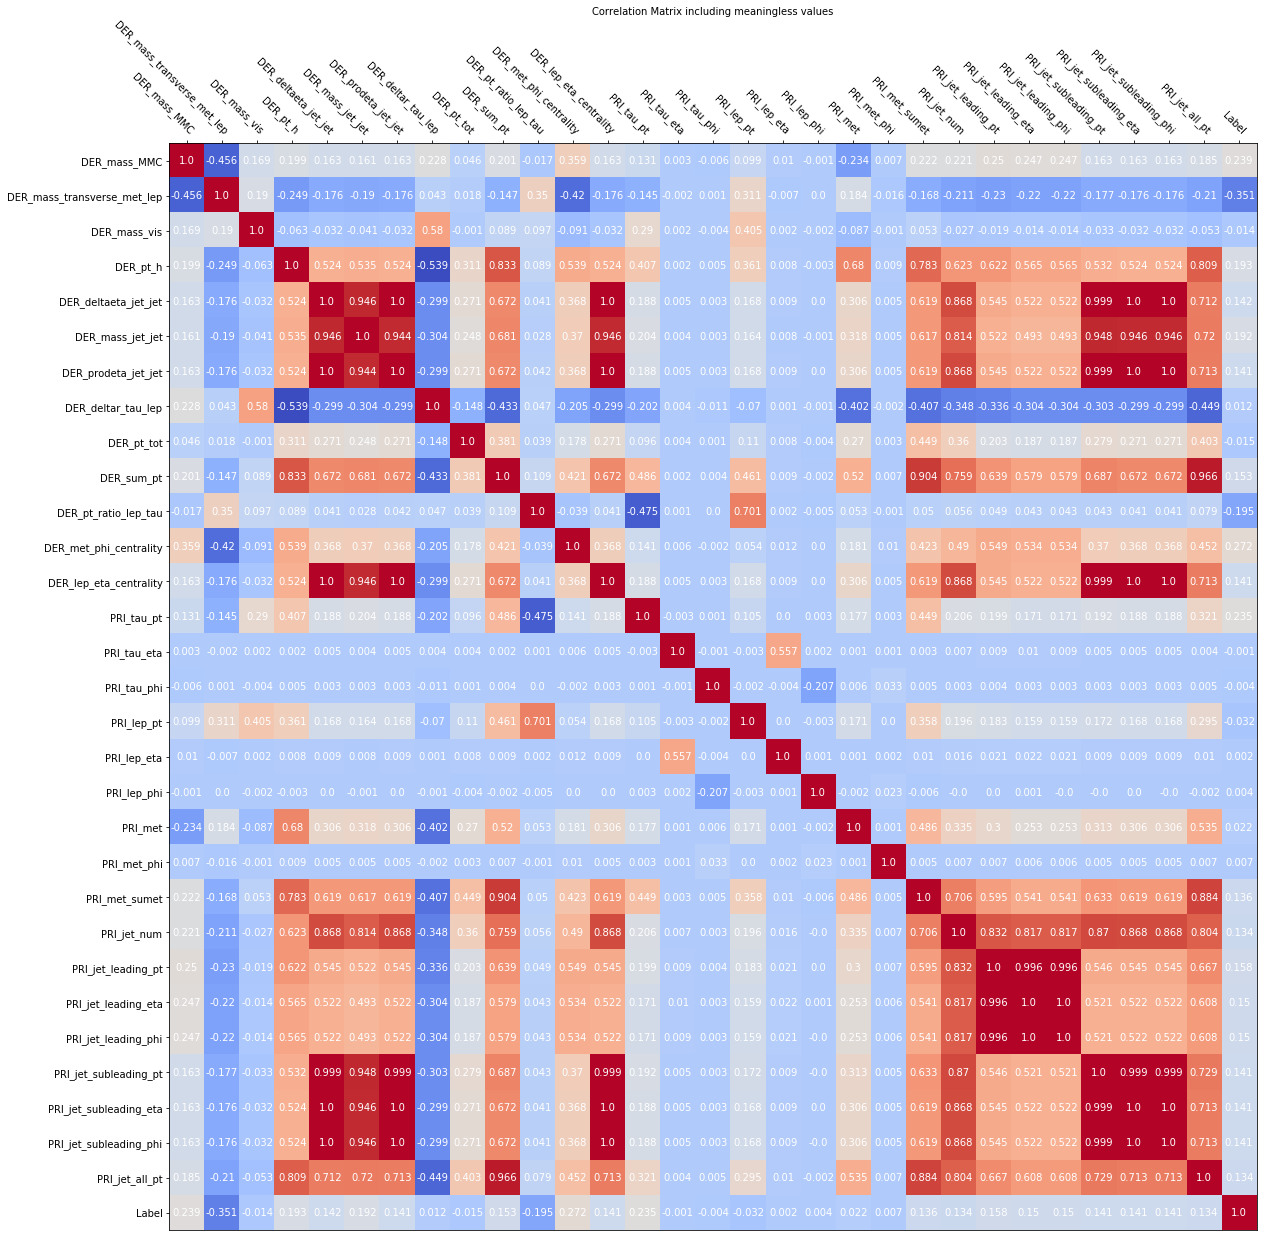

In [73]:
cols = []
for i in range(30):
    cols.append(X_train[:,i])
    
cols.append(y_train)
    
correlations = np.corrcoef(cols)

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(correlations, cmap=cm.coolwarm)

ax.xaxis.set_label_position('top')

# We want to show all ticks...
ax.set_xticks(np.arange(len(columns)+1))
ax.set_yticks(np.arange(len(columns)+1))
# ... and label them with the respective list entries
ax.set_xticklabels(np.append(columns, 'Label'))
ax.set_yticklabels(np.append(columns,'Label'))

# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(columns)+1):
    for j in range(len(columns)+1):
        text = ax.text(j, i, np.around(correlations[i, j],3),
                       ha="center", va="center", color="w")

ax.set_xlabel("Correlation Matrix including meaningless values")

Let's see the correlation matrix of the features that have invalid values imputed.

Text(0.5,0,'Correlation Matrix excluding meaningless values')

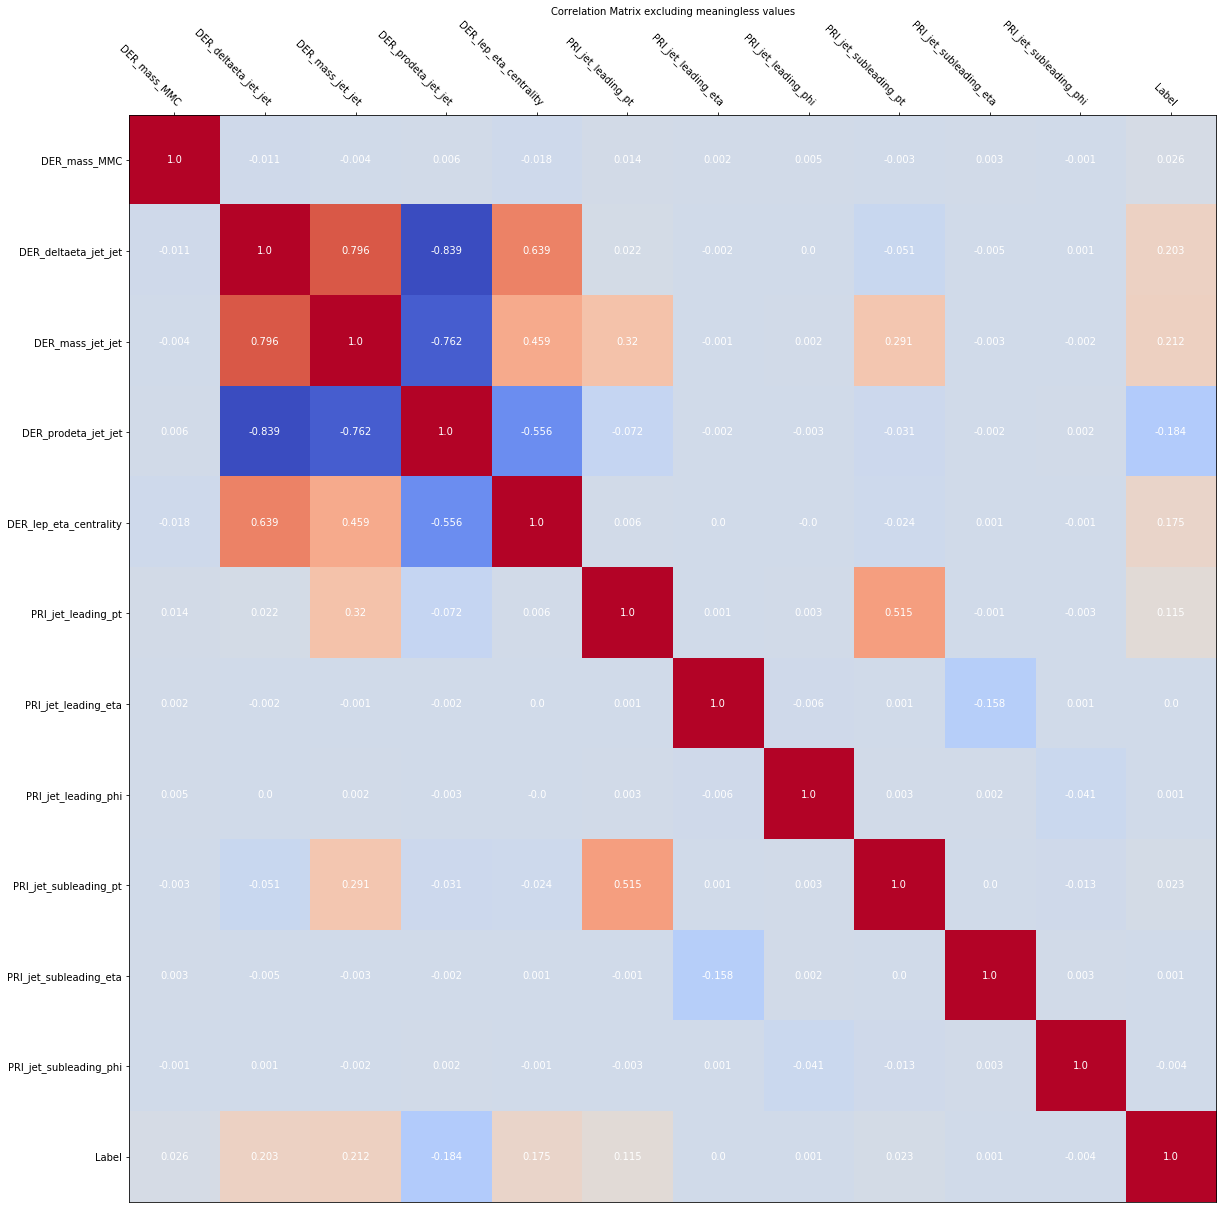

In [56]:
col_num = np.array([0,4,5,6,12,23,24,25,26,27,28])
cols = []

for i in col_num:
    X_train[np.where(X_train[:,i] == -999)[0], i] = np.median(X_train[np.where(X_train[:,i] != -999)[0], i])
    cols.append(X_train[:,i])
    
cols.append(y_train)
    
correlations = np.corrcoef(cols)

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(correlations, cmap=cm.coolwarm)

ax.xaxis.set_label_position('top')

# We want to show all ticks...
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
# ... and label them with the respective list entries
ax.set_xticklabels(np.append(columns[col_num], 'Label'))
ax.set_yticklabels(np.append(columns[col_num], 'Label'))


# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(col_num)+1):
    for j in range(len(col_num)+1):
        text = ax.text(j, i, np.around(correlations[i, j],3),
                       ha="center", va="center", color="w")

ax.set_xlabel("Correlation Matrix excluding meaningless values")

Text(0.5,0,'Correlation Matrix excluding meaningless values')

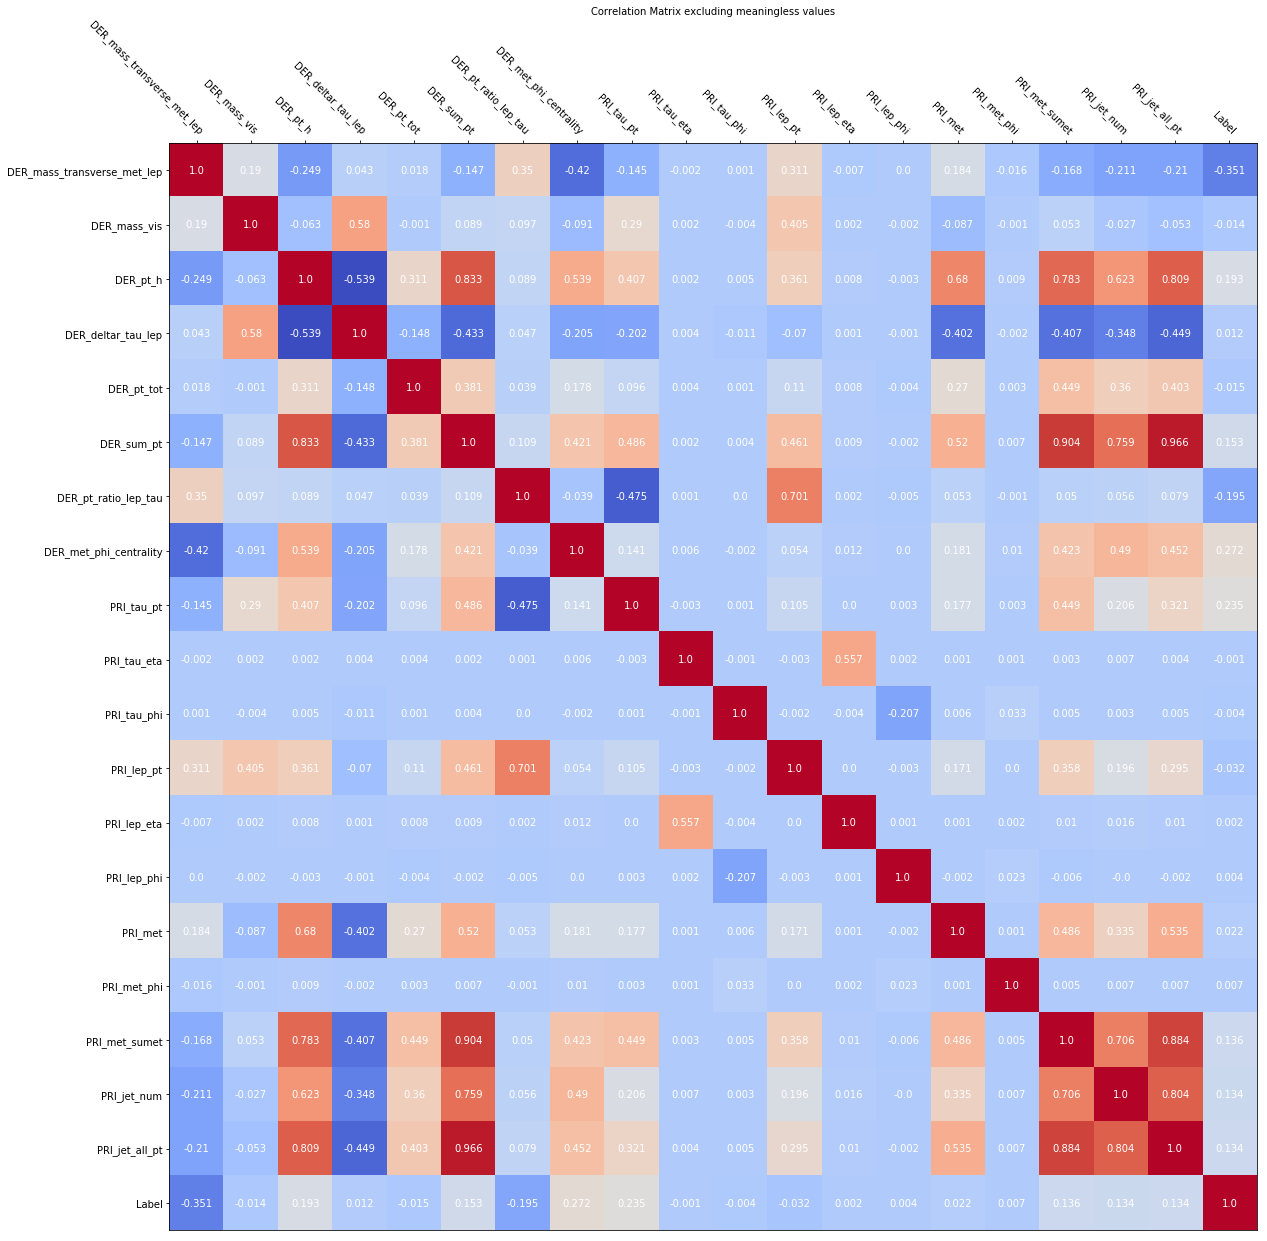

In [229]:
col_num = np.setdiff1d(np.asarray(range(30)), [0,4,5,6,12,23,24,25,26,27,28])
cols = []

for i in col_num:
    cols.append(X_train[:,i])
    
cols.append(y_train)
    
correlations = np.corrcoef(cols)

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(correlations, cmap=cm.coolwarm)

ax.xaxis.set_label_position('top')

# We want to show all ticks...
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
# ... and label them with the respective list entries
ax.set_xticklabels(np.append(columns[col_num], 'Label'))
ax.set_yticklabels(np.append(columns[col_num], 'Label'))



# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(col_num)+1):
    for j in range(len(col_num)+1):
        text = ax.text(j, i, np.around(correlations[i, j],3),
                       ha="center", va="center", color="w")

ax.set_xlabel("Correlation Matrix excluding meaningless values")

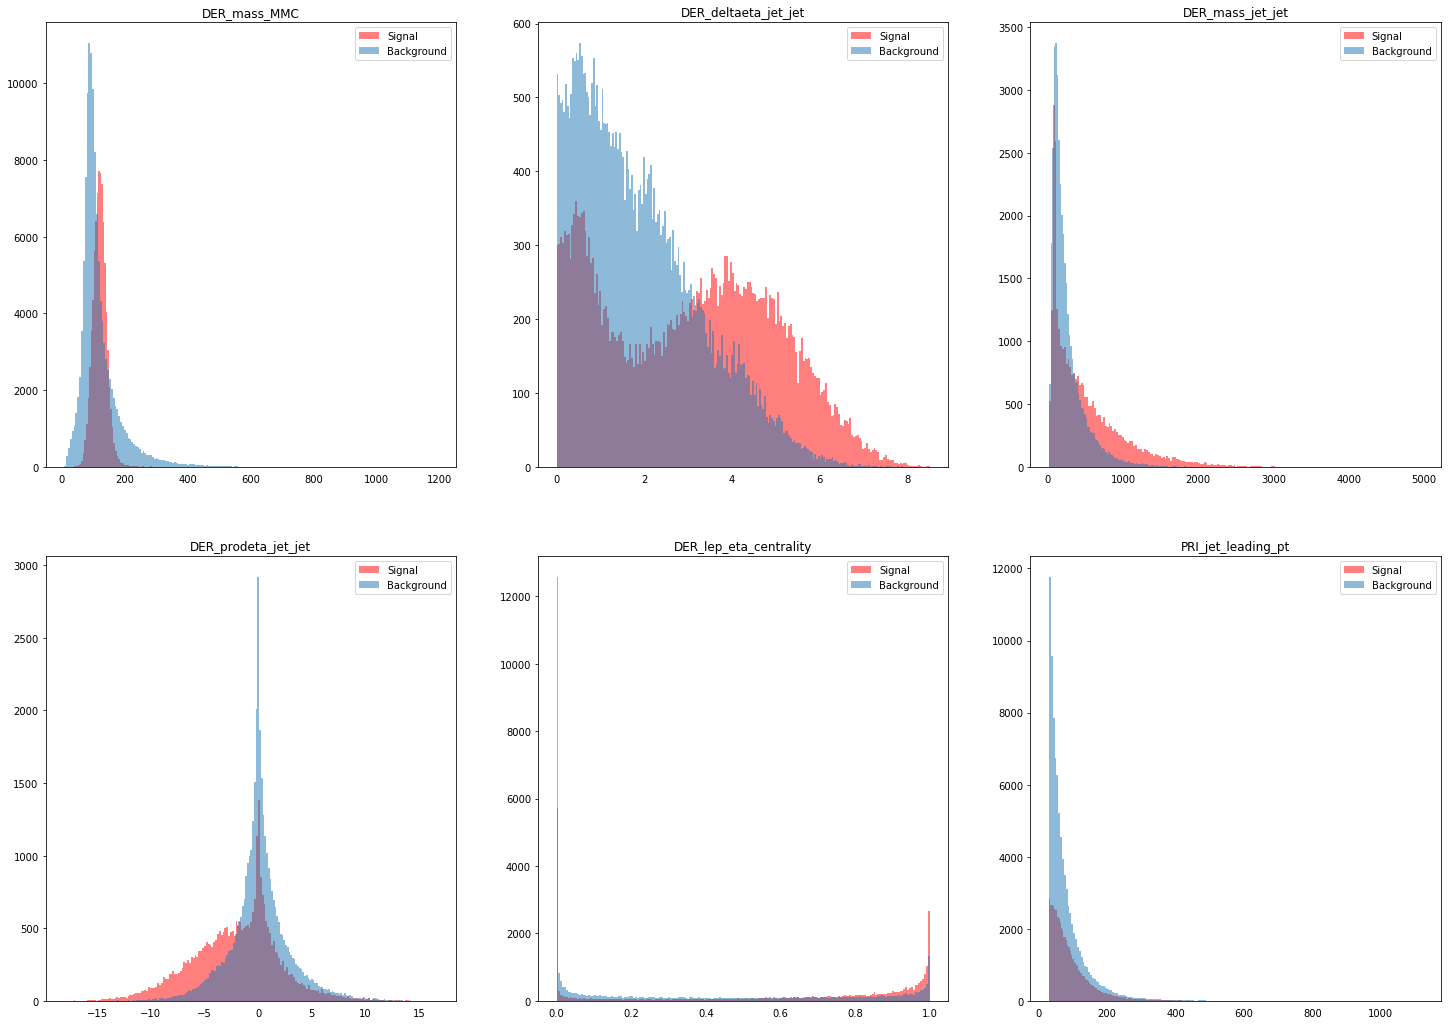

In [485]:
fig, axs = plt.subplots(2, 3, figsize=(25,18))
indices = [0,4,5,6,12,23]
counter = 0
# We can set the number of bins with the `bins` kwarg
for i in range(2):
    for j in range(3):
        axs[i,j].hist(np.array([x for j,x in enumerate(X_train[:,indices[counter]]) if (x != -999 and y_train[j] == 1)]), 
                      bins=200, alpha=0.5, color='red', label='Signal')
        axs[i,j].hist(np.array([x for j,x in enumerate(X_train[:,indices[counter]]) if (x != -999 and y_train[j] == 0)]), 
                      bins=200, alpha=0.5, label = 'Background')
        axs[i, j].set_title(columns[indices[counter]])
        axs[i,j].legend()
        counter += 1

## Correlation between PRI_jet_num with features that have meaningless values

IMPUTE DER_mass_MMC with median

PRI_jet_num = 0
> DER_deltaeta_jet_jet = -999

> DER_mass_jet_jet = -999

> DER_prodeta_jet_jet = -999

> DER_lep_eta_centrality = -999

> PRI_jet_leading_* = -999

> PRI_jet_subleading_* = -999

PRI_jet_num = 1
> DER_deltaeta_jet_jet = -999

> DER_mass_jet_jet = -999

> DER_prodeta_jet_jet = -999

> DER_lep_eta_centrality = -999

> PRI_jet_subleading_* = -999

Training Set 1 - PRI_jet_num = 0

> REMOVE PRI_jet_num

> REMOVE DER_deltaeta_jet_jet = -999

> REMOVE DER_mass_jet_jet = -999

> REMOVE DER_prodeta_jet_jet = -999

> REMOVE DER_lep_eta_centrality = -999

> REMOVE PRI_jet_leading_* = -999

> REMOVE PRI_jet_subleading_* = -999

Training Set 2 - PRI_jet_num = 1

> REMOVE PRI_jet_num

> REMOVE DER_deltaeta_jet_jet = -999

> REMOVE DER_mass_jet_jet = -999

> REMOVE DER_prodeta_jet_jet = -999

> REMOVE DER_lep_eta_centrality = -999

> REMOVE PRI_jet_subleading_* = -999

Training Set 3 - PRI_jet_num = 2,3

> REMOVE PRI_jet_num

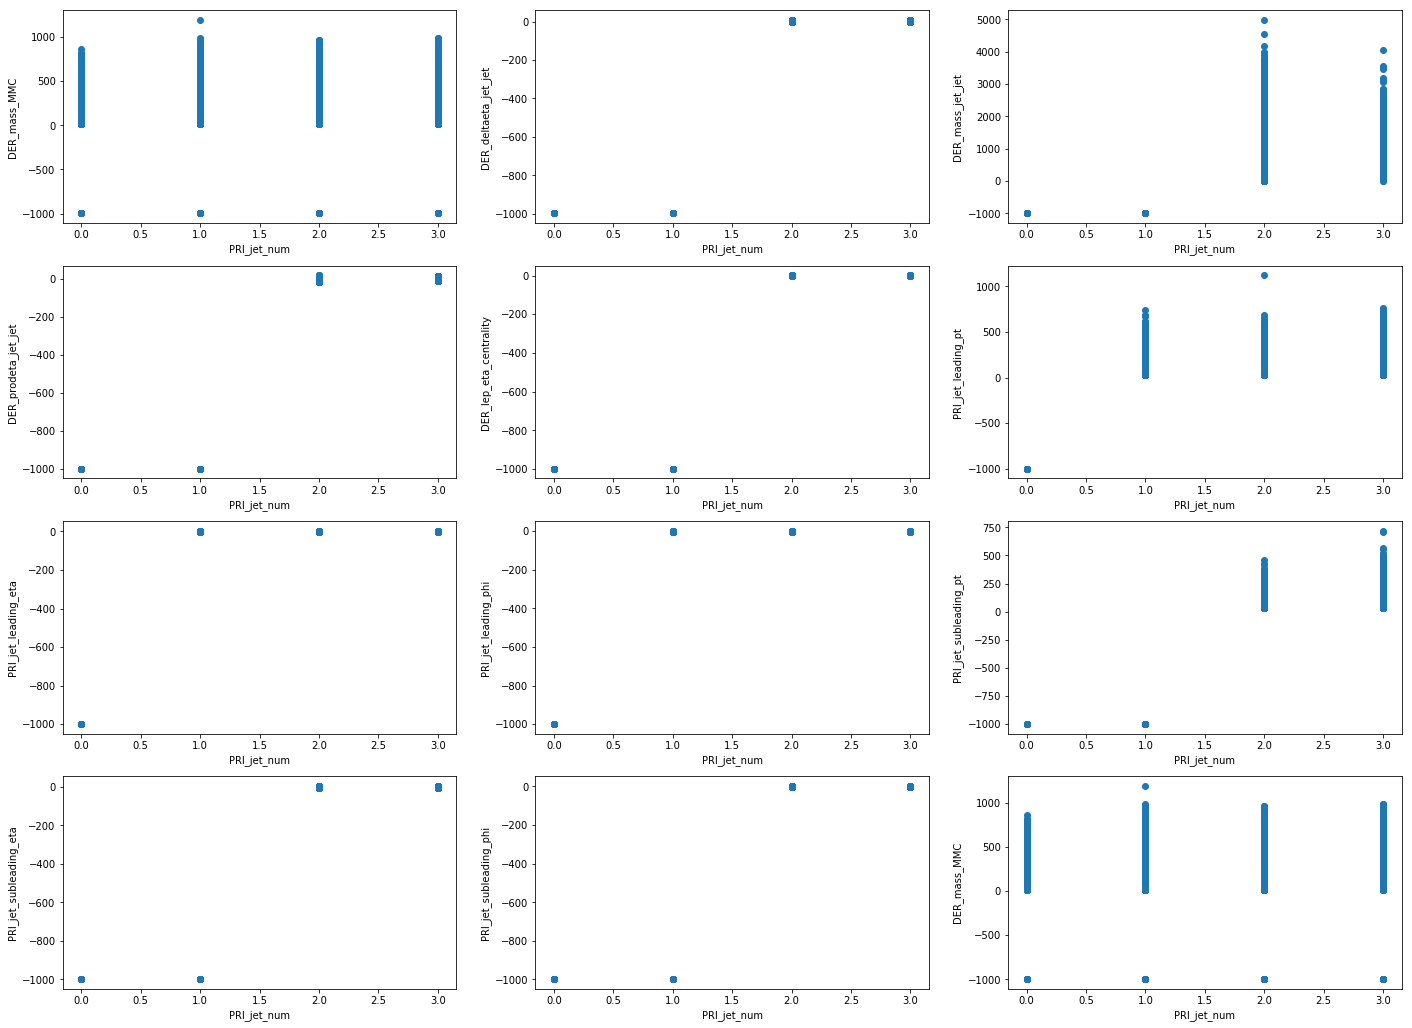

In [74]:
fig, axs = plt.subplots(4, 3, figsize=(24,18))
columns_170k = [0,4,5,6,12,23,24,25,26,27,28,0]
counter = 0
# We can set the number of bins with the `bins` kwarg
for i in range(4):
    for j in range(3):
        axs[i, j].scatter(X_train[:,22], X_train[:,columns_170k[counter]])
        axs[i, j].set_ylabel(columns[columns_170k[counter]])
        axs[i, j].set_xlabel(columns[22])
        #axs[i,j].legend()
        counter += 1

# Start Running From Here

## Feature Selection

Use these features that do not have meaningless values (High correlation with Label): 15 features

- 3 - DER_pt_h  **log transform**
- 9 - DER_sum_pt **log transform**
- 11 - DER_met_phi_centrality
- 1 - DER_mass_transverse_met_lep
- 10 - DER_pt_ratio_lep_tau
- 13 - PRI_tau_pt **(log transform needed)**
- 21 - PRI_met_sumet **log**
- 22 - PRI_jet_num
- 29 - PRI_jet_all_pt **log**

Choose features that have meaningless values:

- 0 - DER_mass_MMC
- 4 - DER_deltaeta_jet_jet
- 5 - DER_mass_jet_jet **log**
- 6 - DER_prodeta_jet_jet
- 12 - DER_lep_eta_centrality
- 23 - PRI_jet_leading_pt **log**

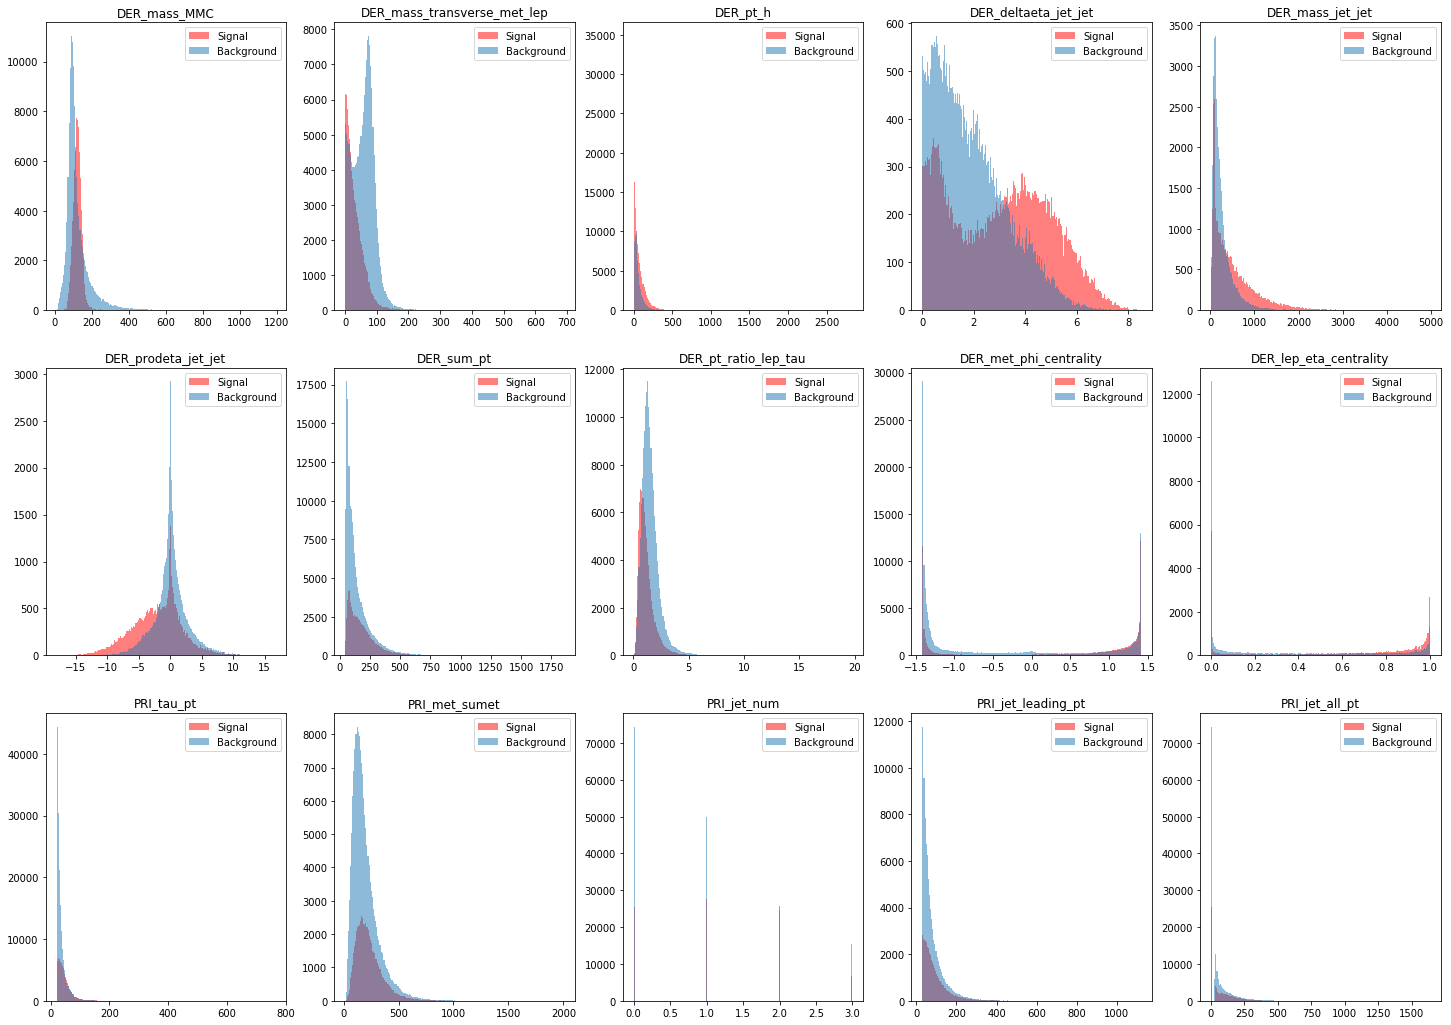

In [78]:
selected_features = np.sort([0,4,5,6,12,23,3,9,11,1,10,13,21,22,29])

fig, axs = plt.subplots(3, 5, figsize=(25,18))
counter = 0
# We can set the number of bins with the `bins` kwarg
for i in range(3):
    for j in range(5):
        axs[i,j].hist(np.array([x for j,x in enumerate(X_train[:,selected_features[counter]]) if (x != -999 and y_train[j] == 1)]), 
                      bins=200, alpha=0.5, color='red', label='Signal')
        axs[i,j].hist(np.array([x for j,x in enumerate(X_train[:,selected_features[counter]]) if (x != -999 and y_train[j] == 0)]), 
                      bins=200, alpha=0.5, label = 'Background')
        axs[i, j].set_title(columns[selected_features[counter]])
        axs[i,j].legend()
        counter += 1

## Data Transformation & Standartization & Imputation

### 1) Data Imputation

Some features are log-transformed to obtain some normality.
We leave meaningless values as they are in order not break correlation between other features.

### 2) Data Transformation

Some features are log-transformed to obtain some normality.

In [93]:
X_train[:,5]

array([ 124.711, -999.   , -999.   , ..., -999.   , -999.   , -999.   ])

In [90]:
# Standartize et, -999ları koru ama onları hesaba katma standartizasyon sırasında
log_transformed_columns = [3,9,13,21,29,5,23]
train_X = np.zeros(X_train.shape[0]).reshape(X_train.shape[0], -1)

for i in selected_features:
    
    added_column = np.zeros(X_train.shape[0])
    
    if i in log_transformed_columns:
        if i in [5,23]:
            added_column[np.where(X_train[:,i] != -999)] = np.log(X_train[np.where(X_train[:,i] != -999),i] + 1)
            added_column[np.where(X_train[:,i] == -999)] = -999
        else:
            added_column = np.log(X_train[:, i] + 1)
    else:
        added_column = X_train[:, i]
        
    train_X = np.column_stack((train_X, added_column))

train_X = np.delete(train_X,0,1)
train_X.shape

(250000, 15)

In [87]:
np.save("pure_features", train_X)
np.save("reg_y", train_y)
np.save("log_y", y_train)

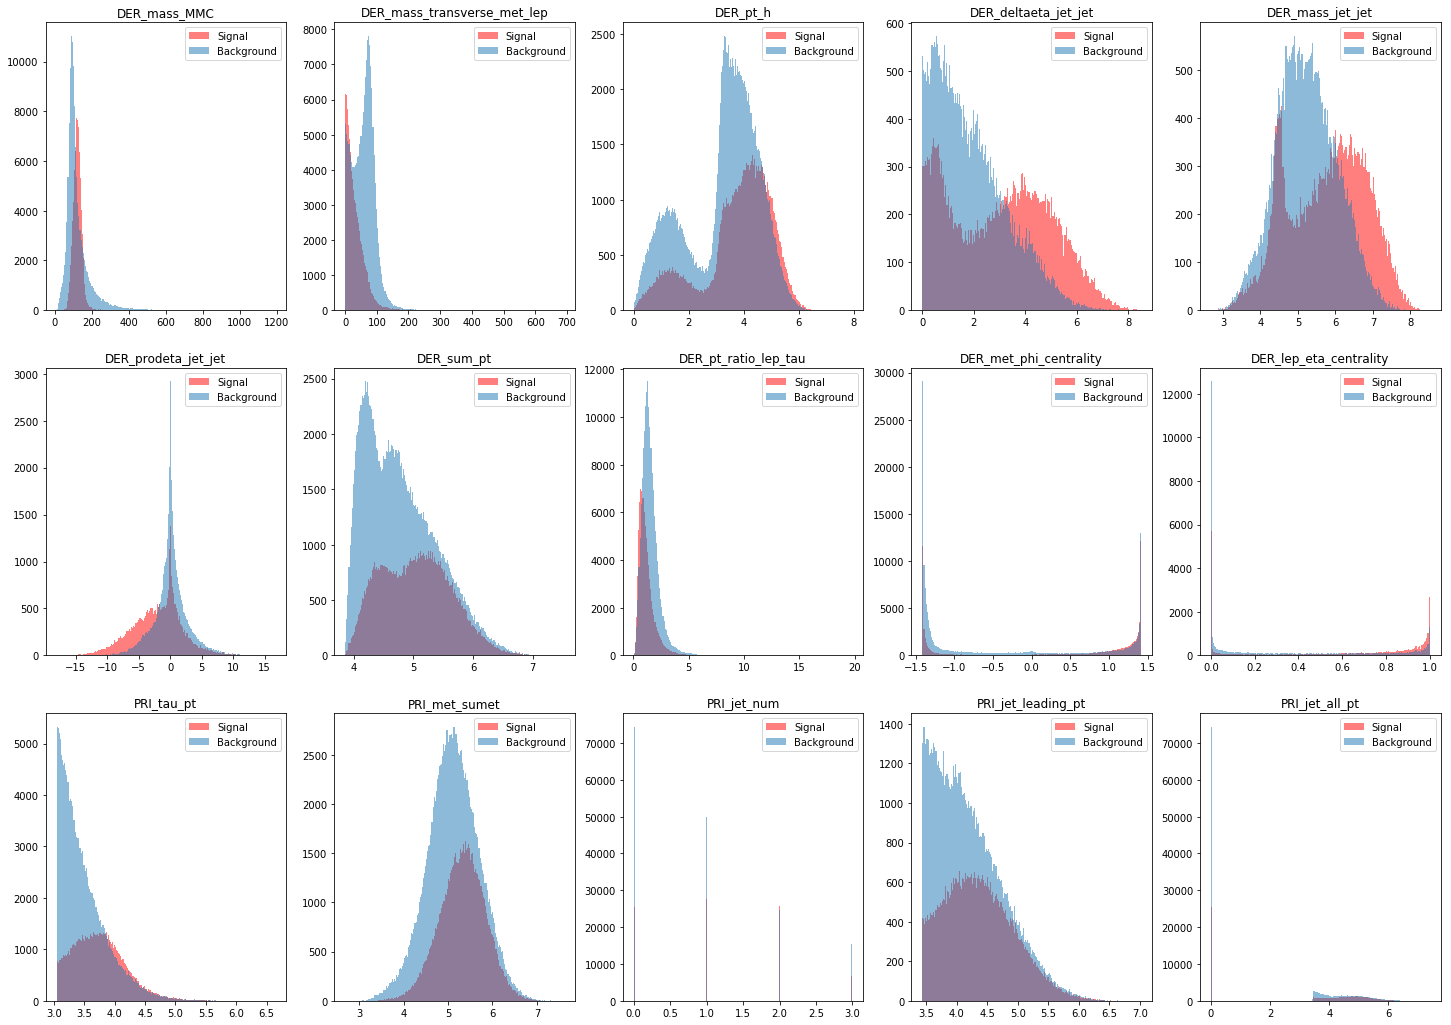

In [55]:
fig, axs = plt.subplots(3, 5, figsize=(25,18))
counter = 0
# We can set the number of bins with the `bins` kwarg
for i in range(3):
    for j in range(5):
        axs[i,j].hist(np.array([x for j,x in enumerate(train_X[:,counter]) if (x != -999 and y_train[j] == 1)]), 
                      bins=200, alpha=0.5, color='red', label='Signal')
        axs[i,j].hist(np.array([x for j,x in enumerate(train_X[:,counter]) if (x != -999 and y_train[j] == 0)]), 
                      bins=200, alpha=0.5, label = 'Background')
        axs[i, j].set_title(columns[selected_features[counter]])
        axs[i,j].legend()
        counter += 1

### 3) Feature Extraction

In [20]:
from implementations import ridge_regression
from proj1_helpers import predict_labels
from proj1_helpers import create_csv_submission

# In order to use least squares model, 0 label is transformed to -1
train_y = y_train.copy()
train_y[train_y == 0] = -1
train_y

array([ 1., -1., -1., ...,  1., -1., -1.])

In [34]:
col_names = []
which_columns = []


squared_feat = np.zeros(train_X.shape[0]).reshape(train_X.shape[0], -1)
j = 1
    
for x, i in enumerate(selected_features):
    for z in range(j, len(selected_features)):
        added_column = train_X[:,x] * train_X[:,z]
        
        added_column[np.where(X_train[:,i] == -999)] = -999
        added_column[np.where(X_train[:,selected_features[z]] == -999)] = -999
        
        squared_feat = np.column_stack((squared_feat,added_column))
        which_columns.append((i, selected_features[z]))
        
        col_names.append(columns[i] + '  *  ' + columns[selected_features[z]])
    j+=1

squared_feat = np.delete(squared_feat,0,1)
squared_feat.shape

(250000, 105)

In [35]:
cols = []
col_names = np.array(col_names)

for i in range(105):
    cols.append(squared_feat[:,i])
    
cols.append(train_y)
    
correlations = np.corrcoef(cols)

print(correlations.shape)
high_corr_feat = squared_feat[:,np.where((correlations[-1,:] > 0.28) & (correlations[-1,:] != 1))].reshape(250000,-1)
print("High correlated features: {}".format(col_names[np.where((correlations[-1,:] > 0.28) & (correlations[-1,:] != 1))[0]]))
high_corr_feat.shape

(106, 106)
High correlated features: ['DER_mass_MMC  *  DER_met_phi_centrality'
 'DER_pt_h  *  DER_met_phi_centrality']


(250000, 2)

In [40]:
train_X = np.column_stack((train_X, high_corr_feat))
train_X.shape

(250000, 17)

## Add polynomial features

In [60]:
for i in range(train_X.shape[1]):
    new_col = train_X[:,i]**2
    train_X = np.column_stack((train_X, new_col))

train_X.shape

(250000, 30)

### 4) Data Standartization

We standartized the features with zero-mean and unit variance.

In [67]:
for i in range(train_X.shape[1]):
    col_val = train_X[:, i]
    train_X[:, i] = (col_val - np.min(col_val)) / (np.max(col_val) - np.min(col_val)) 

In [12]:
np.save("train_X", train_X)
np.save("train_y", train_y)

## Simplest Ridge Regression Model

In [68]:
# Rank of train set must be equal to the feature number
# in order not to have Rank deficiency veya ill condition.

print("train_X rank: {}".format(np.linalg.matrix_rank(train_X)))

train_X rank: 30


### Cross Validation

In [24]:
lambdas = np.logspace(-8, 0, 10)
threshold = np.linspace(-0.4, 0,5)
print(lambdas)
print(threshold)

[1.00000000e-08 7.74263683e-08 5.99484250e-07 4.64158883e-06
 3.59381366e-05 2.78255940e-04 2.15443469e-03 1.66810054e-02
 1.29154967e-01 1.00000000e+00]
[-0.4 -0.3 -0.2 -0.1  0. ]


In [25]:
from cross_validation import split_cross_validation
from cross_validation import build_k_indices

In [26]:
acc_tr, acc_te = cross_validation(train_y, train_X, 5, lambdas, thresholds=threshold)

In [31]:
print("Best model: {}".format(acc_te[40:50][np.argmax(acc_te[40:50][:,2])]))

Best model: [0.000e+00 1.000e-08 7.523e-01]


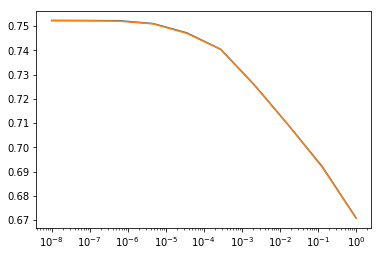

In [30]:
plt.plot(acc_tr[40:50][:,1],acc_tr[40:50][:,2])
plt.plot(acc_te[40:50][:,1],acc_te[40:50][:,2])
plt.xscale('log')

In [76]:
test_set = load_csv_data('../test.csv')
test_y, test_X, ids, columns = test_set

print("Test_X shape: {}".format(test_X.shape))
print("\nTest_Y shape: {}".format(test_y.shape))
print("\nColumn names: {}".format(columns))
print("\nColumn shape: {}".format(columns.shape))

n_features = len(columns)

Test_X shape: (568238, 30)

Test_Y shape: (568238,)

Column names: ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt']

Column shape: (30,)


## Simplest Ridge Regression Model - Data Transformation

In [77]:
# Standartize et, -999ları koru ama onları hesaba katma standartizasyon sırasında
X_test = np.zeros(test_X.shape[0]).reshape(test_X.shape[0], -1)

for i in selected_features:
    
    added_column = np.zeros(test_X.shape[0])
    
    if i in log_transformed_columns:
        if i in [5,23]:
            added_column[np.where(test_X[:,i] != -999)] = np.log(test_X[np.where(test_X[:,i] != -999),i] + 1)
            added_column[np.where(test_X[:,i] == -999)] = -999
        else:
            added_column = np.log(test_X[:, i] + 1)
    else:
        added_column = test_X[:, i]
        
    X_test = np.column_stack((X_test, added_column))

X_test = np.delete(X_test,0,1)
X_test.shape

(568238, 15)

## Simplest Ridge Regression Model - Feature Extraction

In [19]:
add_col = np.array(which_columns)[np.where((correlations[-1,:] > 0.25) & (correlations[-1,:] != 1))]
new_fet = np.zeros(X_test.shape[0]).reshape(X_test.shape[0], -1)
j = 1

for i in add_col:
    first_ind = np.where(i[0] == selected_features)[0][0]
    second_ind = np.where(i[1] == selected_features)[0][0]
    
    added_column = X_test[:,first_ind] * X_test[:,second_ind]
        
    added_column[np.where(test_X[:,i[0]] == -999)] = -999
    added_column[np.where(test_X[:,i[1]] == -999)] = -999
        
    new_fet = np.column_stack((new_fet,added_column))


new_fet = np.delete(new_fet,0,1)
new_fet.shape

(568238, 12)

In [20]:
X_test = np.column_stack((X_test, new_fet))
X_test.shape

(568238, 27)

## Simplest Best Ridge Regression Model - Data Standartization

In [66]:
for i in range(X_test.shape[1]):
    train_col_val = train_X[:, i]
    X_test[:, i] = (X_test[:, i] - np.min(train_col_val)) / (np.max(train_col_val) - np.min(train_col_val))

NameError: name 'X_test' is not defined

In [37]:
w, _ = ridge_regression(train_y, train_X, 1e-8)
predictions = predict_labels(w, X_test)
len(predictions)

568238

In [81]:
train_X.max()

1.0

In [38]:
create_csv_submission(ids, predictions, 'output.csv')

# Least Squares Model

In [14]:
# Least Squares GD and SGD

#np.random.seed(23)
#h_pars = {}
#h_pars['epoch'] = np.linspace(1000,3000,3).astype(int)
#h_pars['l_rate'] = [10**x for x in np.linspace(-4,0,5)]
#h_pars['initial_w'] = np.random.normal(0,1,train_X.shape[1])

In [45]:
par = {}
par['threshold'] = np.linspace(-0.4, 0.4,9)
par['threshold']

array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4])

In [69]:
train_X

array([[5.19149476e-01, 7.48541825e-02, 4.23464480e-01, ...,
        4.44444444e-01, 6.07805246e-06, 4.10492419e-01],
       [5.29403576e-01, 9.96529363e-02, 4.89902164e-01, ...,
        1.11111111e-01, 3.07451186e-06, 2.71446478e-01],
       [0.00000000e+00, 2.35006340e-01, 4.52947967e-01, ...,
        1.11111111e-01, 2.74631183e-06, 2.65463569e-01],
       ...,
       [5.04082106e-01, 8.77093070e-02, 4.66359480e-01, ...,
        1.11111111e-01, 2.35769942e-06, 2.58379375e-01],
       [4.99287092e-01, 2.80578198e-02, 3.36399267e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05432018e-01, 2.68874505e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [70]:
train_X.shape

(250000, 30)

In [71]:
acc_tr, acc_te = cross_validation(train_y, train_X, 5, h_pars=par, model='least')

In [72]:
acc_tr

array([[-0.4     ,  0.699846],
       [-0.3     ,  0.728323],
       [-0.2     ,  0.747547],
       [-0.1     ,  0.756963],
       [ 0.      ,  0.756921],
       [ 0.1     ,  0.749336],
       [ 0.2     ,  0.73667 ],
       [ 0.3     ,  0.719711],
       [ 0.4     ,  0.703901]])

In [73]:
acc_te

array([[-0.4     ,  0.699884],
       [-0.3     ,  0.728332],
       [-0.2     ,  0.747572],
       [-0.1     ,  0.756696],
       [ 0.      ,  0.756536],
       [ 0.1     ,  0.749316],
       [ 0.2     ,  0.736652],
       [ 0.3     ,  0.719416],
       [ 0.4     ,  0.70376 ]])

In [82]:
from implementations import least_squares

w, _ = least_squares(train_y, train_X)
predictions = predict_labels(w, X_test, -0.1)

# Logistic Regression

In [12]:
par = {}
par['gamma'] = np.logspace(-5,0,10)
par['max_iter'] = [2000*x for x in range(1,8)]

In [13]:
print(train_X.shape)
print(y_train.shape)
train_X
train_y

(250000, 27)
(250000,)


array([ 1., -1., -1., ...,  1., -1., -1.])

In [86]:
def accuracy(pred, y):
    counter = 0
    for i in range(len(pred)):
        if pred[i] == y[i]:
            counter+=1
            
    return counter/len(pred)

accuracy(train_set_pred, train_y)

0.622052

In [14]:
from implementations import logistic_regression
w, loss = logistic_regression(y_train, train_X, np.zeros(27), 100, 0.001)

[0.26894142 0.5        0.5        ... 0.26894142 0.5        0.5       ]
[0. 0. 0. ... 0. 0. 0.]
iter: 0 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 1 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 2 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 3 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 4 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 5 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 6 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 7 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 8 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 9 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 10 - loss: 6.31217782259535
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
iter: 11 - l

In [27]:
loss

0.9827368023280388

# Create Test Set Predictions

In [89]:
create_csv_submission(ids, predictions, 'output.csv')